In [1]:
import os
import numpy as np
import tensorflow as tf
import json
import random
import copy

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing import image
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt

data_folder = 'data_2'

In [2]:
with open('database_2.json') as json_file:
    y = json.load(json_file)
    
detect = 'F'

In [3]:
%%time
x_train = []
y_train = []

for file_name in os.listdir(data_folder):
    img_path = os.path.join(data_folder, file_name)
    img = image.load_img(img_path, target_size=(32, 32))
    x = image.img_to_array(img)
    x = x/255
    
    """
    plt.figure(figsize=(3,3))
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x, cmap=plt.cm.binary)
    plt.show()
    """
    
    x_train += [x]
    y_train += [np.array(y[file_name])]
    
x_valid = np.array(x_train)[:1000]
y_valid = np.array(y_train)[:1000]

x_train = np.array(x_train)[1000:]
y_train = np.array(y_train)[1000:]

Wall time: 23.1 s


In [4]:
%%time
x_train = np.append(x_train, np.rot90(x_train, 2, axes=(1,2)), axis=0)
y_train = np.append(y_train, np.rot90(y_train, 2, axes=(1,2)), axis=0)
x_train = np.append(x_train, np.rot90(x_train, 1, axes=(1,2)), axis=0)
y_train = np.append(y_train, np.rot90(y_train, 1, axes=(1,2)), axis=0)

Wall time: 719 ms


In [5]:
%%time
def transform_y(y, transform_base=None):
    y_flatten = []

    for k in range(len(y)):
        y_flatten += [y[k].flatten()]

    y = np.array(y_flatten)

    y_transformed = np.zeros(y.shape)
    if transform_base is None:
        transform_base = {}
    alpha = 0

    for k in range(len(y)):
        for j in range(len(y[k])):
            if y[k,j] not in transform_base.keys():
                transform_base[y[k,j]] = alpha
                alpha += 1

            y_transformed[k, j] = transform_base[y[k,j]]
            
    return y_transformed, transform_base

y_train_transformed, transform_base = transform_y(y_train)
y_valid_transformed, transform_base = transform_y(y_valid, transform_base=transform_base)

Wall time: 1.46 s


In [6]:
model = models.Sequential()
model.add(layers.ZeroPadding2D((1,1), input_shape=(32, 32, 3)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.ZeroPadding2D((1,1)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.ZeroPadding2D((1,1)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(25, activation='sigmoid'))

In [7]:
y_train_O = (y_train_transformed == transform_base[detect]).astype(int)
y_valid_O = (y_valid_transformed == transform_base[detect]).astype(int)

In [8]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

history = model.fit(x_train, y_train_O, epochs=15, validation_data=(x_valid, y_valid_O))

Epoch 1/15
1125/1125 [==============================] - 45s 40ms/step - loss: 0.4215 - binary_accuracy: 0.8121 - val_loss: 0.2309 - val_binary_accuracy: 0.9050
Epoch 2/15
1125/1125 [==============================] - 46s 41ms/step - loss: 0.1783 - binary_accuracy: 0.9273 - val_loss: 0.1394 - val_binary_accuracy: 0.9430
Epoch 3/15
1125/1125 [==============================] - 44s 39ms/step - loss: 0.1084 - binary_accuracy: 0.9573 - val_loss: 0.0988 - val_binary_accuracy: 0.9614
Epoch 4/15
1125/1125 [==============================] - 46s 40ms/step - loss: 0.0784 - binary_accuracy: 0.9701 - val_loss: 0.0787 - val_binary_accuracy: 0.9709
Epoch 5/15
1125/1125 [==============================] - 45s 40ms/step - loss: 0.0613 - binary_accuracy: 0.9769 - val_loss: 0.0643 - val_binary_accuracy: 0.9751
Epoch 6/15
1125/1125 [==============================] - 44s 39ms/step - loss: 0.0502 - binary_accuracy: 0.9813 - val_loss: 0.0642 - val_binary_accuracy: 0.9753
Epoch 7/15
1125/1125 [==================

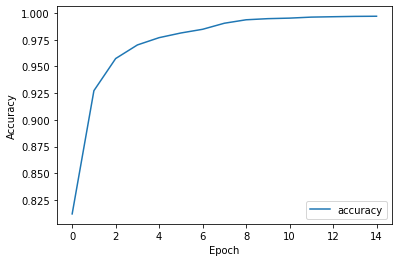

In [16]:
plt.plot(history.history['binary_accuracy'], label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Test sur des photos

In [10]:
x_test = []
y_test = []

with open('database.json') as json_file:
    y = json.load(json_file)

for file_name in os.listdir('data'):
    img_path = os.path.join('data', file_name)
    img = image.load_img(img_path, target_size=(32, 32))
    x = image.img_to_array(img)
    x = x/255
    
    """
    plt.figure(figsize=(3,3))
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x, cmap=plt.cm.binary)
    plt.show()
    """
    
    x_test += [x]
    y_test += [np.array(y[file_name])]
    
x_test = np.array(x_test)
y_test_transformed, transform_base = transform_y(y_test, transform_base=transform_base)
y_test_O = (y_test_transformed == transform_base[detect]).astype(int)

In [17]:
f1_score(model.predict(x_test).round().flatten(),
        y_test_O.flatten())

0.6162162162162163

In [18]:
random_y = copy.deepcopy(y_test_O.flatten())
random.shuffle(random_y)

In [20]:
f1_score(random_y,
         y_test_O.flatten())

0.18421052631578946

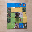

In [26]:
image.array_to_img(x_test[2])

In [27]:
model.predict(x_test).round()[2].reshape(5,5)

array([[0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 1.],
       [1., 1., 0., 0., 0.],
       [1., 1., 0., 1., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)